## Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Network Architecture

In [4]:
torch.cuda.is_available()

True

In [5]:
dtype = torch.cuda.FloatTensor

In [322]:
class eelfff(nn.Module):
    
    def __init__(self, grid_size, output, layer_size=2048):
        super(eelfff, self).__init__()
        self.grid_size = grid_size
        self.output = output
        self.layer_size = layer_size
        
        # inputs: image + rot vec + id compare + pos-other_pos
        self.net = nn.Sequential(
                                nn.Linear(self.grid_size**2, self.layer_size),
                                nn.ReLU(inplace=True),
                                nn.Linear(self.layer_size, self.layer_size),
                                nn.ReLU(inplace=True),
                                nn.Linear(self.layer_size, self.output)
                            )

    def forward(self, feat):
        return self.net(feat)

test network with random data

In [8]:
tic = time.clock()
N = 32
grid_size = 10
output = 10**2

model = eelfff(grid_size, output).type(dtype)
feat = Variable(torch.randn(N,grid_size**2)).type(dtype)
Q = model(feat)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([32, 100])
304.78s = 5.08m elapsed for this test


In [243]:
fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]

## Heuristic

In [293]:
def heuristic(sim, size_control):
    action = []
    grid_size = sim.grid_size
    center = (grid_size+1)//2
    cc = x_to_col(center)
    center_idx = np.asscalar(np.ravel_multi_index(np.array([[cc],[cc]]),(grid_size,grid_size),order='F'))
    fires = sim.fires
    scores = {}
    for s in range(5):
        scores[s] = []
        
    for (x,y) in fires:
        rf = y_to_row(grid_size,y)
        cf = x_to_col(x)
        
        counter = 0
        for (dr,dc) in fire_neigh:
            rn = rf + dr
            cn = cf + dc
            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                counter += 1
                
        e = np.ravel_multi_index(np.array([[rf],[cf]]),(grid_size,grid_size),order='F')
        scores[counter].append(np.asscalar(e))
        
    using_set = 4
    while(len(action) < size_control):
        if using_set >= 0:
            if not scores[using_set]:
                using_set += -1
                continue

            for e in scores[using_set]:
                action.append(e)

                if len(action) >= size_control:
                    break
                    
            using_set += -1
    
        else:
            action.append(center_idx)
            
    return action
    

## Benchmark greedy solution

In [703]:
results = []

In [704]:
grid_size = 500
num_control = 100
seeds = range(1000)

In [705]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    seed_rew = 0
    control = []
    
    while not sim.end:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        action = heuristic(sim, num_control)
        reward, control = eelfff_reward(sim.state, action, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
        
        seed_rew += reward
                    
    if (i+1) % 100 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

finished 100 simulations
finished 200 simulations
finished 300 simulations
finished 400 simulations
finished 500 simulations
finished 600 simulations
finished 700 simulations
finished 800 simulations
finished 900 simulations
finished 1000 simulations
6.12s = 0.10m elapsed


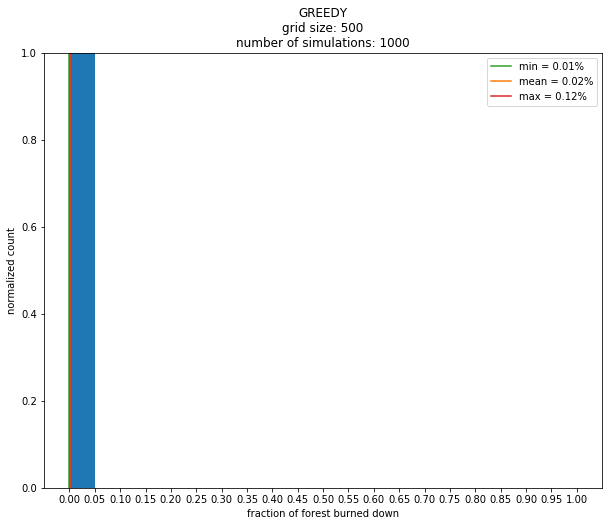

In [706]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('GREEDY\ngrid size: %d\nnumber of simulations: %d' %(grid_size,len(results)))
plt.legend(loc=1)

# plt.savefig('greedy.png', bbox_inches='tight')

In [707]:
with open('greedy_%d+%d+%d.pkl' %(grid_size,num_control,len(seeds)), 'wb') as fp:
    pickle.dump(results, fp)

## Reward function

In [682]:
def eelfff_reward(state, action, size_control):
    reward = 0
    
    ctrl = []
    grid_size = state.shape[0]
    r,c = np.unravel_index(action, (grid_size,grid_size), order='F')
    for (rp,cp) in zip(r,c):
        x = col_to_x(cp)
        y = row_to_y(grid_size,rp)

        if (x,y) not in ctrl and state[rp,cp] in [1]:
            counter = 0
            for (dr,dc) in fire_neigh:
                rn = rp + dr
                cn = cp + dc
                if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                    counter += 1
                
            reward += 2*counter / len(fire_neigh)
            
        ctrl.append((x,y))

    reward /= size_control
            
    return reward, ctrl

## Train the network

In [683]:
# simulator parameters
grid_size = 10
output = grid_size**2
num_control = 10
dp = 0.15/0.2763

# replay memory
memory_size = 5000 #5000
min_exp_size = 100 #100
exp_size = (grid_size**2)*2 + 1 + num_control
sars = None

state_st = grid_size**2
action_st = state_st
action_ed = action_st + num_control
reward_st = action_ed
next_state_st = reward_st + 1

# network instances
layer_size = 2048
model = eelfff(grid_size, output, layer_size).type(dtype)
target = eelfff(grid_size, output, layer_size).type(dtype)
update_max = 200 #200
update_ctr = 1

# optimizer
gamma = 0.95
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# exploration
eps_init = 1
eps_finl = 0.25
anneal_range = 1000 #2000
eps = eps_init
episode_ctr = 0

# loss function
loss_fn = nn.MSELoss(size_average=True)

# plotting data structures
rew_hist = []
loss_hist = []

pf1 = False
pf2 = False

In [684]:
seeds = range(1000)

In [685]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    seed_rew = 0
    control = []
    
    while not sim.end and sim.iter < 35:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        action = None
        if np.random.rand() <= eps:
            #action = np.random.randint(0, high=grid_size**2, size=num_control)
            action = heuristic(sim, num_control)

        else:
            state_var = Variable(torch.from_numpy(state)).type(dtype)
            Q = model(state_var.unsqueeze(0))[0].data.cpu().numpy()
            action = np.argpartition(Q, -num_control)[-num_control:]
            
        reward, control = eelfff_reward(sim.state, action, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
        
        # generate next state and save experience
        next_state = sim.state.reshape((grid_size**2, ))
        
        if sars is None:
            sars = np.zeros((1, exp_size))
        else:
            sars = np.vstack((sars, np.zeros((1,exp_size))))    
        
        sars[-1,0:state_st]  = state
        sars[-1,action_st:action_ed] = action
        sars[-1,reward_st] = reward
        sars[-1,next_state_st:] = next_state
        seed_rew += reward
        
        # skip network update if not enough experiences
        if sars is None or sars.shape[0] < min_exp_size or sars.shape[0] < batch_size:
            continue
        elif not pf1:
            pf1 = True
            print('---DEBUG: generated enough experiences')
                        
        # create a batch of experiences from memory and update network
        loss = 0
        
        batch = sars[np.random.choice(sars.shape[0], batch_size, replace=False), :]
        batch_states = Variable(torch.from_numpy(batch[:,0:state_st])).type(dtype)
        batch_actions = Variable(torch.from_numpy(batch[:,action_st:action_ed])).type(torch.cuda.LongTensor)
        x = model(batch_states).gather(1, batch_actions).mean(dim=1)
        
        batch_rewards = batch[:,reward_st]
        batch_next_states = Variable(torch.from_numpy(batch[:,next_state_st:])).type(dtype)
        tt = target(batch_next_states).data.cpu().numpy()
        tt = batch_rewards + gamma*np.mean(np.sort(tt, axis=1)[:,-num_control:], axis=1)
        tt = Variable(torch.from_numpy(tt), requires_grad=False).type(dtype)
        loss += loss_fn(x, tt)

        loss_hist.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
            
        # anneal exploration rate
        if eps > eps_finl:
            eps += -(eps_init - eps_finl)/anneal_range
        elif not pf2:
            pf2 = True
            print('---DEBUG: finished annealing the exploration rate')
        
        # update target network periodically
        if update_ctr % update_max == 0:
            target = copy.deepcopy(model)
            print('---DEBUG: updated target network (%d)' %(update_ctr / update_max))
        update_ctr += 1
        
        # drop from memory if too many elements
        if sars.shape[0] > memory_size:
            sars = sars[sars.shape[0]-memory_size:,:]   
                    
    frac_burn = sim.stats[2]/np.sum(sim.stats)
    print('seed %03d: %03d steps, %0.2f reward, %0.4f burnt' %(s, sim.iter, seed_rew, frac_burn))
    rew_hist.append(seed_rew)
    episode_ctr += 1
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

seed 000: 010 steps, 3.80 reward, 0.3400 burnt
seed 001: 011 steps, 4.40 reward, 0.3800 burnt
seed 002: 013 steps, 4.85 reward, 0.4500 burnt
seed 003: 007 steps, 2.30 reward, 0.3000 burnt
seed 004: 008 steps, 3.10 reward, 0.3200 burnt
seed 005: 012 steps, 5.00 reward, 0.4400 burnt
seed 006: 013 steps, 2.80 reward, 0.2800 burnt
seed 007: 007 steps, 2.40 reward, 0.2600 burnt
seed 008: 010 steps, 2.85 reward, 0.2800 burnt
seed 009: 010 steps, 4.55 reward, 0.4300 burnt
seed 010: 010 steps, 4.55 reward, 0.4200 burnt
seed 011: 007 steps, 3.60 reward, 0.3300 burnt
seed 012: 005 steps, 2.05 reward, 0.2300 burnt
---DEBUG: generated enough experiences
seed 013: 012 steps, 6.55 reward, 0.5400 burnt
seed 014: 013 steps, 5.45 reward, 0.4800 burnt
seed 015: 012 steps, 6.35 reward, 0.5500 burnt
seed 016: 011 steps, 5.70 reward, 0.4300 burnt
seed 017: 015 steps, 5.40 reward, 0.4600 burnt
seed 018: 017 steps, 4.35 reward, 0.4100 burnt
seed 019: 017 steps, 7.05 reward, 0.5800 burnt
seed 020: 015 steps, 

seed 162: 026 steps, 2.55 reward, 0.5000 burnt
seed 163: 035 steps, 3.95 reward, 0.9600 burnt
seed 164: 025 steps, 4.85 reward, 0.6400 burnt
seed 165: 025 steps, 5.60 reward, 0.7500 burnt
seed 166: 010 steps, 1.85 reward, 0.2400 burnt
seed 167: 014 steps, 2.50 reward, 0.3400 burnt
seed 168: 018 steps, 3.60 reward, 0.4100 burnt
seed 169: 018 steps, 4.20 reward, 0.5400 burnt
seed 170: 030 steps, 4.75 reward, 0.8700 burnt
---DEBUG: updated target network (16)
seed 171: 035 steps, 5.80 reward, 0.7500 burnt
seed 172: 026 steps, 4.40 reward, 0.7800 burnt
seed 173: 035 steps, 3.00 reward, 0.5500 burnt
seed 174: 023 steps, 4.60 reward, 0.7500 burnt
seed 175: 033 steps, 3.65 reward, 0.6000 burnt
seed 176: 035 steps, 4.70 reward, 0.8700 burnt
seed 177: 026 steps, 2.85 reward, 0.6200 burnt
---DEBUG: updated target network (17)
seed 178: 018 steps, 2.90 reward, 0.3800 burnt
seed 179: 035 steps, 3.45 reward, 0.9500 burnt
seed 180: 027 steps, 4.35 reward, 0.7800 burnt
seed 181: 035 steps, 6.10 rewar

---DEBUG: updated target network (35)
seed 322: 035 steps, 4.40 reward, 0.8800 burnt
seed 323: 035 steps, 4.90 reward, 0.9600 burnt
seed 324: 027 steps, 7.10 reward, 0.7700 burnt
seed 325: 027 steps, 3.05 reward, 0.4400 burnt
seed 326: 023 steps, 2.40 reward, 0.4200 burnt
seed 327: 035 steps, 3.30 reward, 0.9500 burnt
seed 328: 033 steps, 4.85 reward, 0.8200 burnt
seed 329: 022 steps, 4.10 reward, 0.6600 burnt
---DEBUG: updated target network (36)
seed 330: 034 steps, 4.15 reward, 0.9000 burnt
seed 331: 029 steps, 4.00 reward, 0.8700 burnt
seed 332: 019 steps, 6.15 reward, 0.8400 burnt
seed 333: 029 steps, 3.10 reward, 0.9700 burnt
seed 334: 023 steps, 4.70 reward, 0.6300 burnt
seed 335: 026 steps, 4.25 reward, 0.6900 burnt
seed 336: 033 steps, 4.40 reward, 0.6100 burnt
seed 337: 029 steps, 3.80 reward, 0.7500 burnt
---DEBUG: updated target network (37)
seed 338: 032 steps, 4.20 reward, 0.9200 burnt
seed 339: 032 steps, 3.90 reward, 0.9000 burnt
seed 340: 026 steps, 3.40 reward, 0.8300

seed 481: 019 steps, 4.20 reward, 0.5800 burnt
seed 482: 019 steps, 3.90 reward, 0.5800 burnt
seed 483: 030 steps, 4.05 reward, 0.6100 burnt
seed 484: 014 steps, 1.90 reward, 0.3200 burnt
seed 485: 024 steps, 4.45 reward, 0.6900 burnt
seed 486: 023 steps, 3.50 reward, 0.6600 burnt
seed 487: 021 steps, 4.75 reward, 0.7800 burnt
seed 488: 035 steps, 4.10 reward, 0.8100 burnt
seed 489: 016 steps, 2.50 reward, 0.3800 burnt
---DEBUG: updated target network (56)
seed 490: 035 steps, 2.95 reward, 0.5800 burnt
seed 491: 032 steps, 4.75 reward, 0.8300 burnt
seed 492: 022 steps, 4.15 reward, 0.7300 burnt
seed 493: 024 steps, 2.75 reward, 0.3600 burnt
seed 494: 030 steps, 4.20 reward, 0.9400 burnt
seed 495: 008 steps, 1.60 reward, 0.2500 burnt
seed 496: 019 steps, 3.55 reward, 0.3900 burnt
seed 497: 028 steps, 4.20 reward, 0.9000 burnt
seed 498: 013 steps, 2.25 reward, 0.2800 burnt
---DEBUG: updated target network (57)
seed 499: 035 steps, 5.40 reward, 0.6400 burnt
seed 500: 024 steps, 4.55 rewar

---DEBUG: updated target network (75)
seed 640: 023 steps, 5.25 reward, 0.7800 burnt
seed 641: 031 steps, 4.45 reward, 0.8700 burnt
seed 642: 029 steps, 5.25 reward, 0.9000 burnt
seed 643: 022 steps, 3.60 reward, 0.4900 burnt
seed 644: 035 steps, 5.10 reward, 0.7300 burnt
seed 645: 026 steps, 4.40 reward, 0.7800 burnt
seed 646: 024 steps, 3.90 reward, 0.6000 burnt
seed 647: 029 steps, 3.85 reward, 0.8700 burnt
---DEBUG: updated target network (76)
seed 648: 016 steps, 4.70 reward, 0.5100 burnt
seed 649: 013 steps, 3.30 reward, 0.3600 burnt
seed 650: 031 steps, 4.05 reward, 0.9500 burnt
seed 651: 035 steps, 4.85 reward, 0.7400 burnt
seed 652: 024 steps, 4.55 reward, 0.7300 burnt
seed 653: 035 steps, 4.90 reward, 0.7500 burnt
seed 654: 035 steps, 4.00 reward, 0.7500 burnt
seed 655: 035 steps, 5.00 reward, 0.7300 burnt
---DEBUG: updated target network (77)
seed 656: 019 steps, 4.70 reward, 0.5900 burnt
seed 657: 026 steps, 4.50 reward, 0.7800 burnt
seed 658: 027 steps, 6.25 reward, 0.8800

seed 799: 035 steps, 3.30 reward, 0.8500 burnt
seed 800: 035 steps, 5.45 reward, 0.8300 burnt
---DEBUG: updated target network (95)
seed 801: 030 steps, 6.10 reward, 0.9700 burnt
seed 802: 035 steps, 5.30 reward, 0.8000 burnt
seed 803: 021 steps, 2.65 reward, 0.3700 burnt
seed 804: 019 steps, 4.55 reward, 0.6500 burnt
seed 805: 027 steps, 4.60 reward, 0.9500 burnt
seed 806: 019 steps, 5.80 reward, 0.6500 burnt
seed 807: 022 steps, 3.20 reward, 0.4700 burnt
seed 808: 032 steps, 3.75 reward, 0.7100 burnt
---DEBUG: updated target network (96)
seed 809: 035 steps, 4.15 reward, 0.8500 burnt
seed 810: 030 steps, 3.40 reward, 0.5600 burnt
seed 811: 022 steps, 4.50 reward, 0.5700 burnt
seed 812: 031 steps, 4.25 reward, 0.8700 burnt
seed 813: 024 steps, 5.00 reward, 0.9100 burnt
seed 814: 018 steps, 4.55 reward, 0.6200 burnt
seed 815: 035 steps, 5.25 reward, 0.9200 burnt
seed 816: 029 steps, 4.70 reward, 0.6700 burnt
---DEBUG: updated target network (97)
seed 817: 035 steps, 5.40 reward, 0.8400

seed 957: 012 steps, 2.30 reward, 0.2500 burnt
seed 958: 023 steps, 2.75 reward, 0.3300 burnt
seed 959: 028 steps, 4.55 reward, 0.7200 burnt
seed 960: 027 steps, 3.25 reward, 0.6100 burnt
seed 961: 029 steps, 4.10 reward, 0.8100 burnt
seed 962: 011 steps, 2.80 reward, 0.2900 burnt
---DEBUG: updated target network (115)
seed 963: 029 steps, 5.00 reward, 0.7900 burnt
seed 964: 035 steps, 4.05 reward, 0.7500 burnt
seed 965: 027 steps, 3.20 reward, 0.8000 burnt
seed 966: 021 steps, 4.55 reward, 0.7500 burnt
seed 967: 035 steps, 5.20 reward, 0.8400 burnt
seed 968: 025 steps, 4.80 reward, 0.8700 burnt
seed 969: 024 steps, 4.55 reward, 0.6900 burnt
seed 970: 016 steps, 3.85 reward, 0.3700 burnt
---DEBUG: updated target network (116)
seed 971: 031 steps, 4.85 reward, 0.8200 burnt
seed 972: 029 steps, 3.80 reward, 0.7600 burnt
seed 973: 035 steps, 3.80 reward, 0.7700 burnt
seed 974: 011 steps, 3.15 reward, 0.3500 burnt
seed 975: 030 steps, 4.05 reward, 0.8400 burnt
seed 976: 030 steps, 5.50 rew

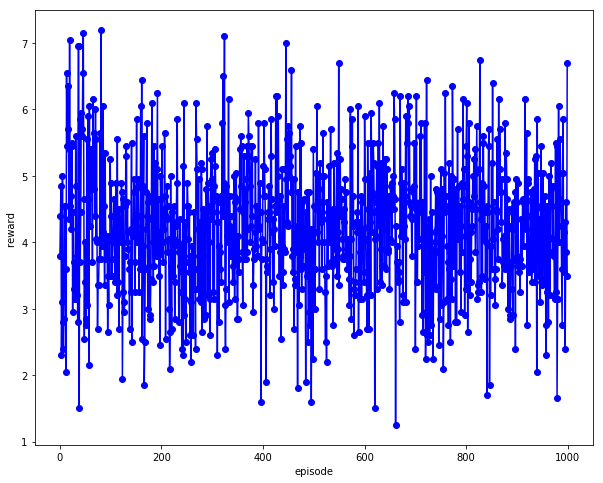

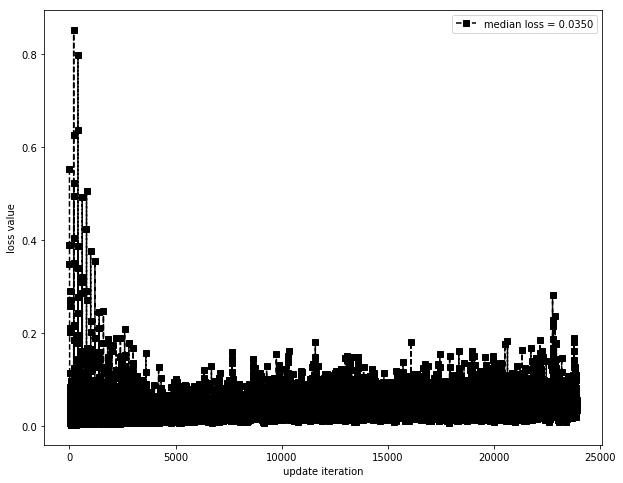

In [686]:
fig = plt.figure()
plt.plot(range(len(rew_hist)), rew_hist, 'b-o')
plt.xlabel('episode')
plt.ylabel('reward ')

fig = plt.figure()
plt.plot(range(len(loss_hist)), loss_hist, 'k--s', label="median loss = %0.4f" %(np.median(loss_hist)))
plt.xlabel('update iteration')
plt.ylabel('loss value')
plt.legend()

In [687]:
Q

array([ 8.89591217,  8.85827065,  9.18972969,  9.52203846,  8.59955597,
        8.91485405,  9.17750549,  8.98080635,  9.21316051,  9.03699017,
        8.82234192,  9.37211514,  8.94669628,  9.0150032 ,  9.08574486,
        9.26729774,  9.08372116,  8.82492256,  9.191432  ,  9.30676174,
        9.03062916,  8.76094627,  8.87773895,  8.66989613,  9.1180563 ,
        9.45562935,  9.0407753 ,  9.48495293,  8.93205929,  9.33017731,
        9.27659225,  9.34628296,  9.31380367,  8.67708492,  9.03608799,
        9.33096981,  8.72496128,  9.08076668,  8.99809265,  9.51788902,
        9.48412991,  9.30968475,  9.27065182,  8.85827541,  9.31876564,
        9.41174984,  8.78328514,  9.56493282,  9.38556194,  9.01648426,
        9.0662117 ,  9.16783905,  9.47409058,  9.52491188,  9.13848495,
        9.25763988,  9.03290176,  9.31268883,  9.55536652,  9.11671829,
        9.16247749,  9.13879395,  9.04418659,  9.1808548 ,  9.09284782,
        9.18420219,  9.17092705,  9.08836555,  8.74028206,  8.84

## Test network in simulation

In [688]:
seed = 1

0.67s = 0.01m elapsed


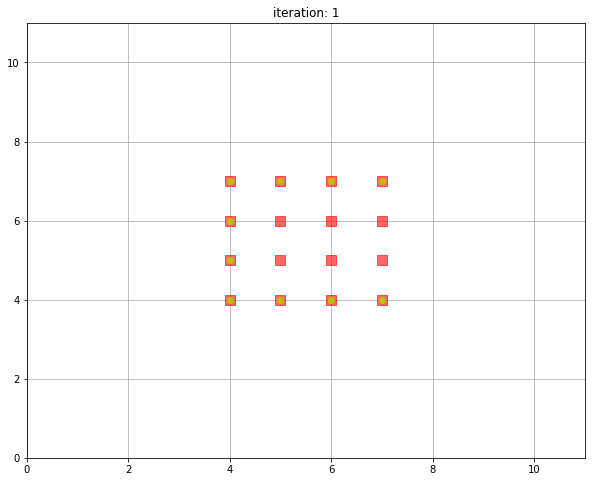

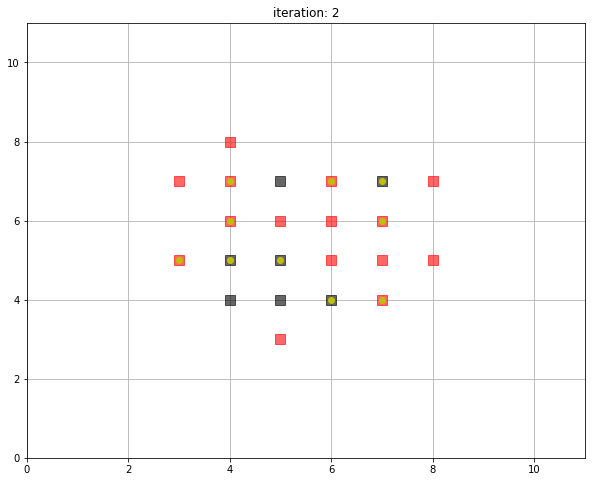

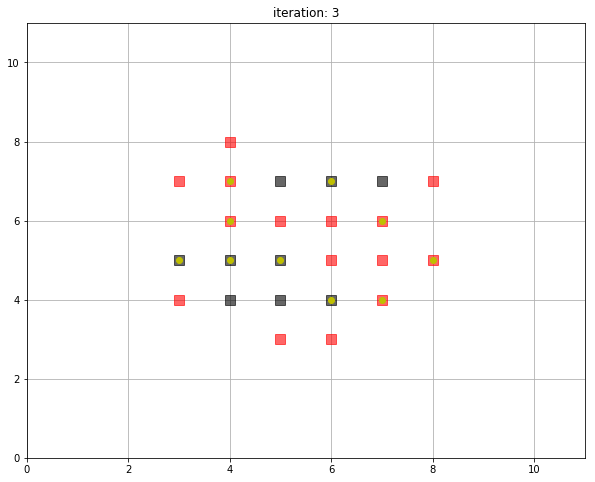

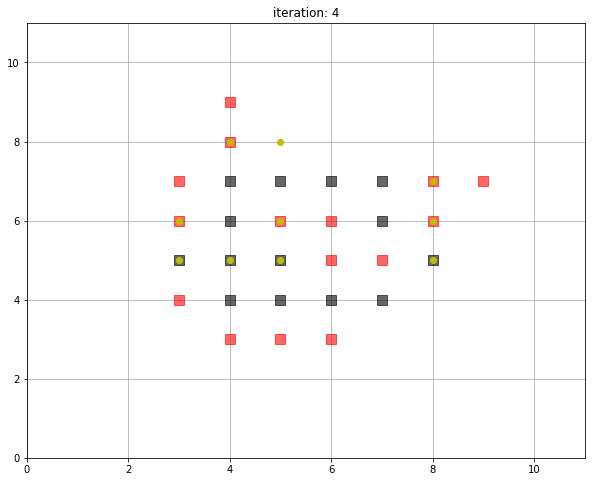

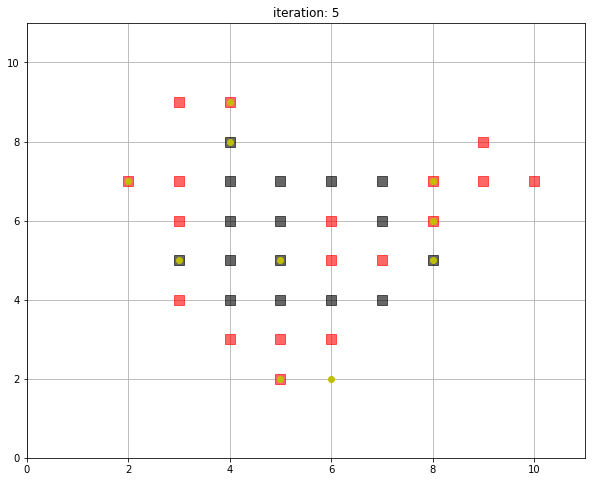

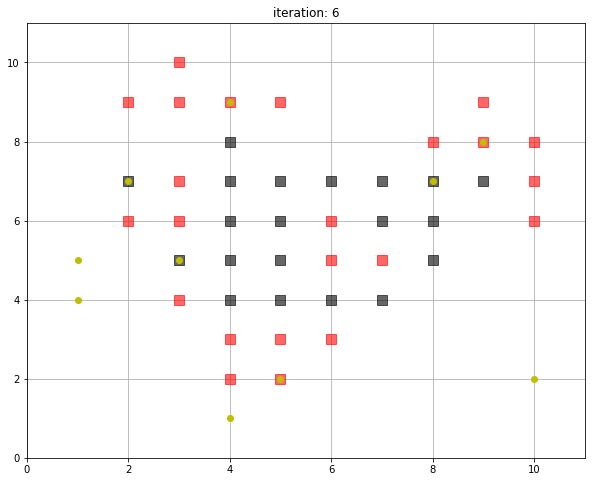

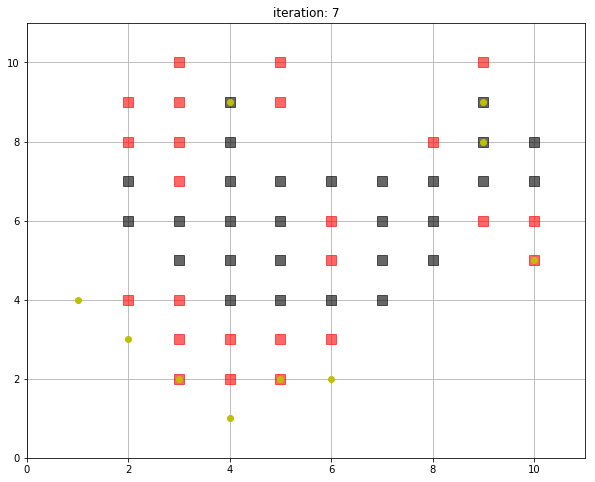

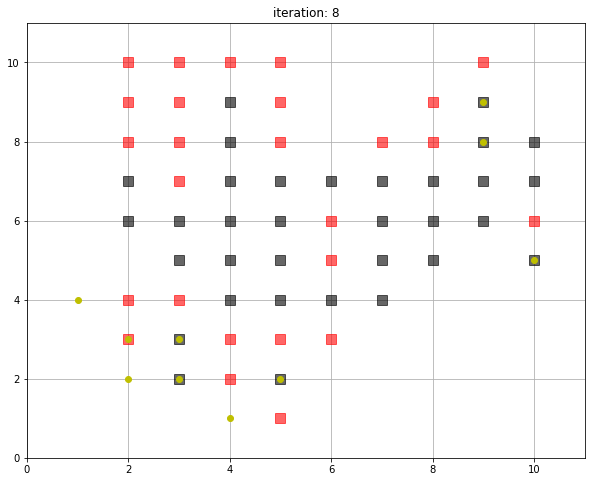

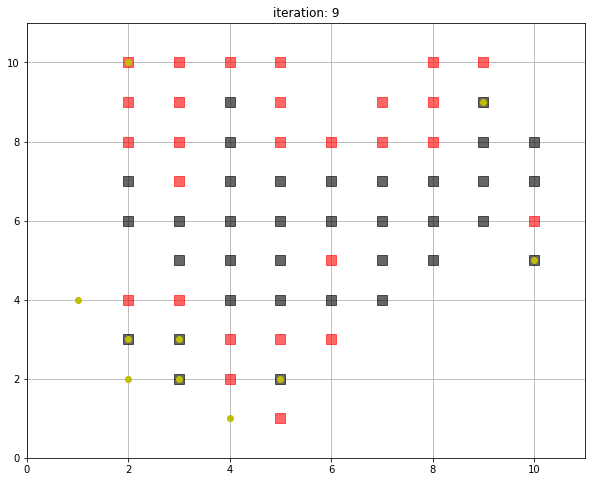

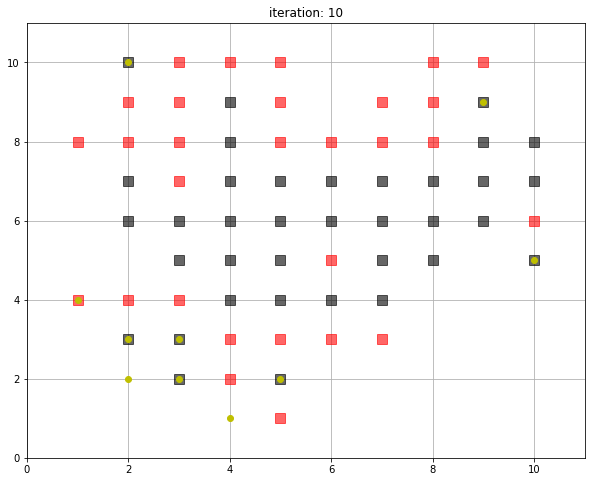

In [689]:
plotting = True
plt.close('all')

tic = time.clock()
# run simulator many times
s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([]) # start fire in domain

seed_rew = 0
control = []

for _ in range(10):
    if plotting:
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d' % (sim.iter))

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6,markersize=10)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6,markersize=10)
                    
    # generate state
    state = sim.state.reshape((grid_size**2, ))

    # get action and reward
    state_var = Variable(torch.from_numpy(state)).type(dtype)
    Q = model(state_var.unsqueeze(0))[0].data.cpu().numpy()
    action = np.argpartition(Q, -num_control)[-num_control:]

    reward, control = eelfff_reward(sim.state, action, num_control)
    
    if plotting:
        for (x,y) in control:
            plt.plot(x,y,"yo")
        
    # apply action and update simulator
    sim.step(control, dbeta=dp)

    seed_rew += reward

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

In [690]:
Q

array([ 15.12224007,  15.19276619,  15.67629719,  14.98778629,
        14.4751215 ,  15.54714394,  16.26939011,  15.49658012,
        15.64139557,  14.71246338,  16.26876068,  15.87403965,
        15.14213467,  15.72482109,  15.58676624,  15.18822384,
        15.79626942,  16.22559929,  16.15470886,  15.79568863,
        15.82482147,  14.98027229,  15.11799717,  14.92497158,
        15.3317852 ,  15.73030472,  15.33495903,  16.24682999,
        16.59613609,  15.92171383,  15.78643608,  15.9521122 ,
        15.8576088 ,  14.41061783,  15.21002579,  15.76548576,
        14.91217518,  15.18813801,  14.94634056,  16.1769352 ,
        15.62429905,  15.36737442,  15.74508858,  14.74525928,
        15.75805187,  15.69890499,  14.73096085,  14.72838879,
        16.42060661,  15.32968998,  14.96360302,  15.28226662,
        15.68189049,  15.35016918,  14.50436306,  15.34137344,
        15.08505535,  15.532547  ,  15.96114445,  15.02719784,
        15.57879353,  14.89655495,  14.97452831,  15.07

## Benchmark network solution

In [691]:
results = []

In [692]:
seeds = range(1000)

In [693]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    seed_rew = 0
    control = []
    
    while not sim.end:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        state_var = Variable(torch.from_numpy(state)).type(dtype)
        Q = model(state_var.unsqueeze(0))[0].data.cpu().numpy()
        action = np.argpartition(Q, -num_control)[-num_control:]

        reward, control = eelfff_reward(sim.state, action, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
        
        seed_rew += reward
                    
    if (i+1) % 100 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

finished 100 simulations
finished 200 simulations
finished 300 simulations
finished 400 simulations
finished 500 simulations
finished 600 simulations
finished 700 simulations
finished 800 simulations
finished 900 simulations
finished 1000 simulations
39.21s = 0.65m elapsed


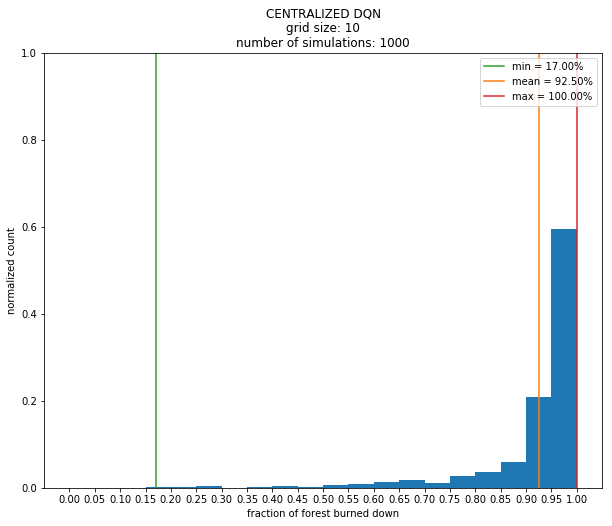

In [694]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('CENTRALIZED DQN\ngrid size: %d\nnumber of simulations: %d' %(grid_size,len(results)))
plt.legend(loc=1)

# plt.savefig('central.png', bbox_inches='tight')

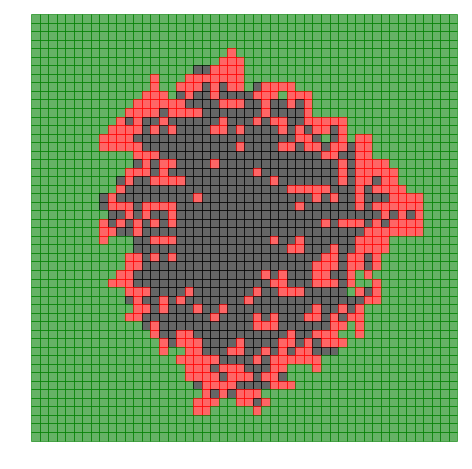

In [732]:
grid_size = 50
s = 2
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)

for _ in range(40):
    sim.step([], dbeta=dp)
    
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plt.xlim([0,grid_size+1])
plt.ylim([0,grid_size+1])
plt.axis('off')

#plt.plot(center,center,"gx")
for i in range(grid_size):
    for j in range(grid_size):
        x = col_to_x(j)
        y = row_to_y(grid_size,i)
        
        if sim.state[i,j] == 0:
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='g')
        elif sim.state[i,j] == 1:
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='r')
        elif sim.state[i,j] == 2:
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6,color='k')           
        
        ax.add_patch(rect)
        
# plt.savefig('forest_fire.pdf', dpi=300, bbox_inches='tight')